In [1]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [2]:
pancontrol = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42781,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:46845,Total threads: 1
Dashboard: /proxy/45861/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:46033,


In [4]:
#Time variant variables #ASK HOW TO CONDENSE
control_SO = pancontrol.search(variable="so", frequency="1mon").to_dask()
control_SOB = pancontrol.search(variable="sob", frequency="1mon").to_dask()
trial_SO = pantrial01.search(variable="so", frequency="1mon").to_dask()
trial_SOB = pantrial01.search(variable="sob", frequency="1mon").to_dask()

In [5]:
#ASK WHY THIS DOESN"T WORK: 
#control = pancontrol.search(variable=["so","sob"], frequency="1mon").to_dask()

In [6]:
#variables = pancontrol.unique().variable
#print(variables)

In [7]:
#Area weighting
data_fixed = pancontrol.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()

In [8]:
areacello = data_fixed.areacello
control_SO = control_SO.assign_coords({"areacello": areacello})
control_SO = control_SO.assign_coords({"areacello": areacello})
control_SOB = control_SOB.assign_coords({"areacello": areacello})
trial_SO = trial_SO.assign_coords({"areacello": areacello})
trial_SOB = trial_SOB.assign_coords({"areacello": areacello})

In [9]:
SOpert_top = trial_SO.so.sel(time=slice('2001-01','2010-01')).mean(dim='time').isel(z_l=0)
SOcont_top = control_SO.so.sel(time=slice('2001-01','2010-01')).mean(dim='time').isel(z_l=0)
SOpert_mid = trial_SO.so.sel(time=slice('2001-01','2010-01')).mean(dim='time').sel(z_l='500', method='nearest')
SOcont_mid = control_SO.so.sel(time=slice('2001-01','2010-01')).mean(dim='time').sel(z_l='500', method='nearest')
SOpert_bot = trial_SOB.sob.sel(time=slice('2001-01','2010-01')).mean(dim='time')
SOcont_bot = control_SOB.sob.sel(time=slice('2001-01','2010-01')).mean(dim='time')

SOanom_top = SOpert_top - SOcont_top
SOanom_mid = SOpert_mid - SOcont_mid
SOanom_bot = SOpert_bot - SOcont_bot
#SOanom_top_test = trial_SO.so.sel(time=slice('2001-01','2010-01')).mean(dim='time').isel(z_l=0) - control_SO.so.sel(time=slice('2001-01','2010-01')).mean(dim='time').isel(z_l=0)

In [10]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [11]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [12]:
depth = data_fixed.deptho#.to_array().squeeze()
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

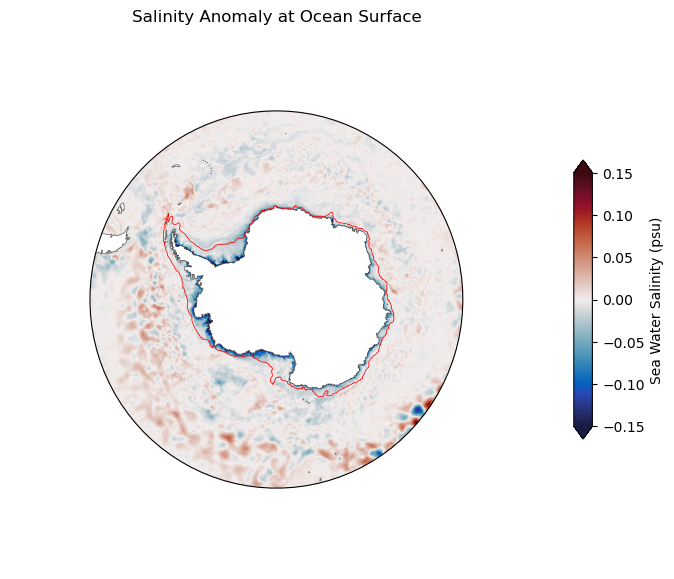

In [16]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

SOanom_top.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity Anomaly at Ocean Surface");

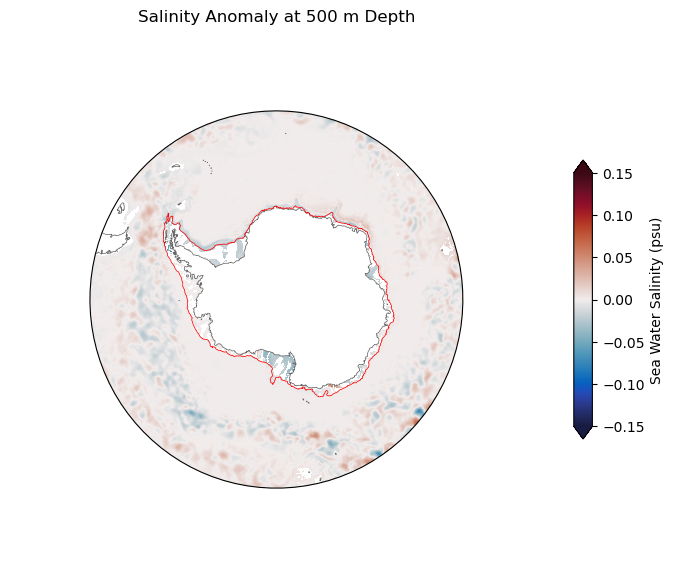

In [17]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SOanom_mid.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity Anomaly at 500 m Depth");

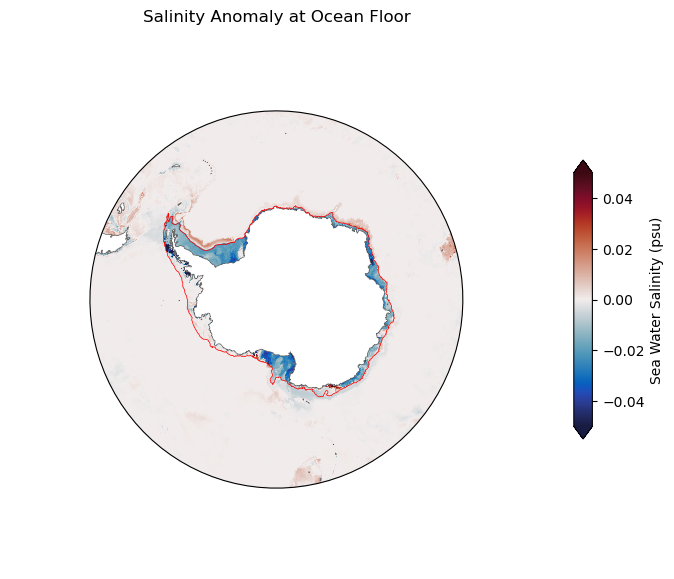

In [18]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

SOanom_bot.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity Anomaly at Ocean Floor");

### Time series plots

In [19]:
SOcont_top_time = control_SO.so.sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOcont_mid_time = control_SO.so.sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOcont_bot_time = control_SOB.sob.sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

SOpert_top_time = trial_SO.so.sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOpert_mid_time = trial_SO.so.sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOpert_bot_time = trial_SOB.sob.sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

In [20]:
SOanom_top_time = SOpert_top_time - SOcont_top_time
SOanom_mid_time = SOpert_mid_time - SOcont_mid_time
SOanom_bot_time = SOpert_bot_time - SOcont_bot_time

Text(0.5, 1.0, 'Time Series of Salinity at Ocean Surface')

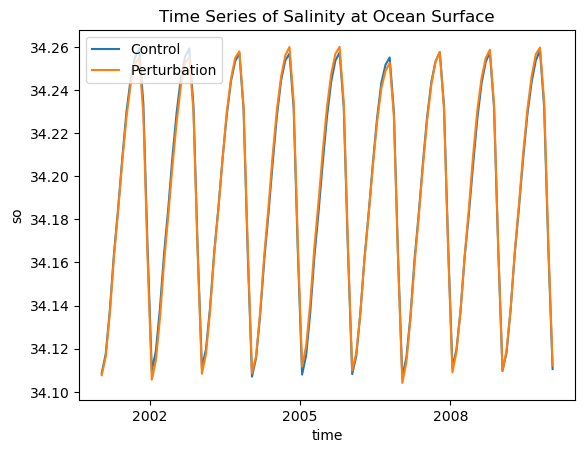

In [27]:
SOcont_top_time.plot(label="Control")
SOpert_top_time.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Salinity at Ocean Surface")

Text(0.5, 1.0, 'Time Series of Salinity at 500 m Depth')

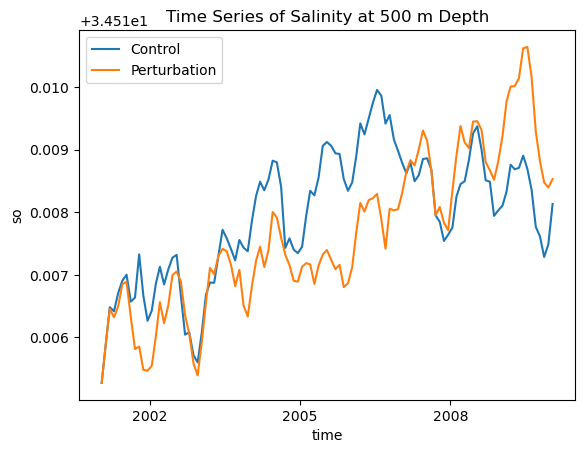

In [28]:
SOcont_mid_time.plot(label="Control")
SOpert_mid_time.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Salinity at 500 m Depth")

Text(0.5, 1.0, 'Time Series of Salinity at Ocean Floor')

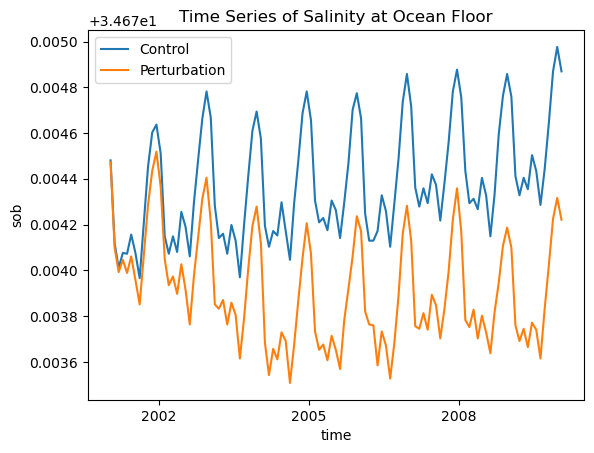

In [29]:
SOcont_bot_time.plot(label="Control")
SOpert_bot_time.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Salinity at Ocean Floor")

Text(0.5, 1.0, 'Time Series of Anomaly Salinity at Ocean Surface')

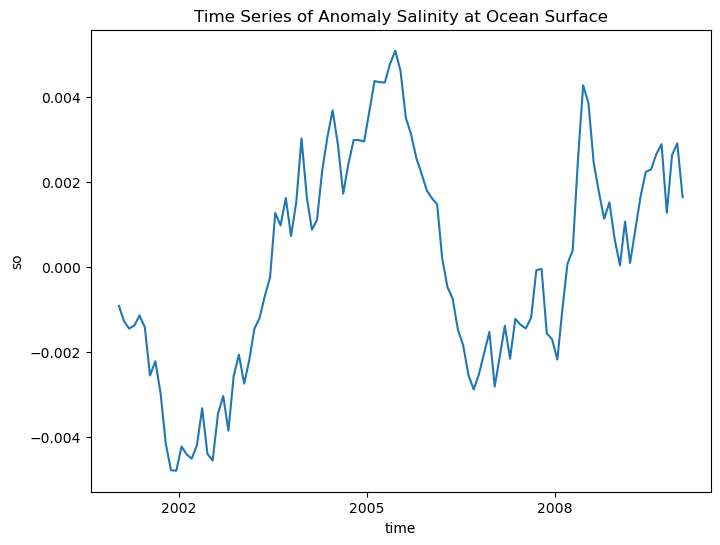

In [30]:
SOanom_top_time.plot(size=6)
plt.title("Time Series of Anomaly Salinity at Ocean Surface")

Text(0.5, 1.0, 'Time Series of Anomaly Salinity at 500 m Depth')

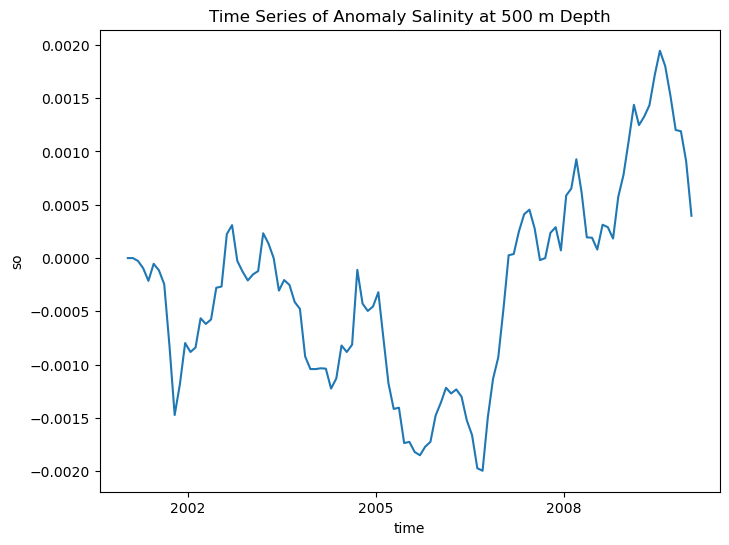

In [31]:
SOanom_mid_time.plot(size=6)
plt.title("Time Series of Anomaly Salinity at 500 m Depth")

Text(0.5, 1.0, 'Time Series of Anomaly Salinity at Ocean Floor')

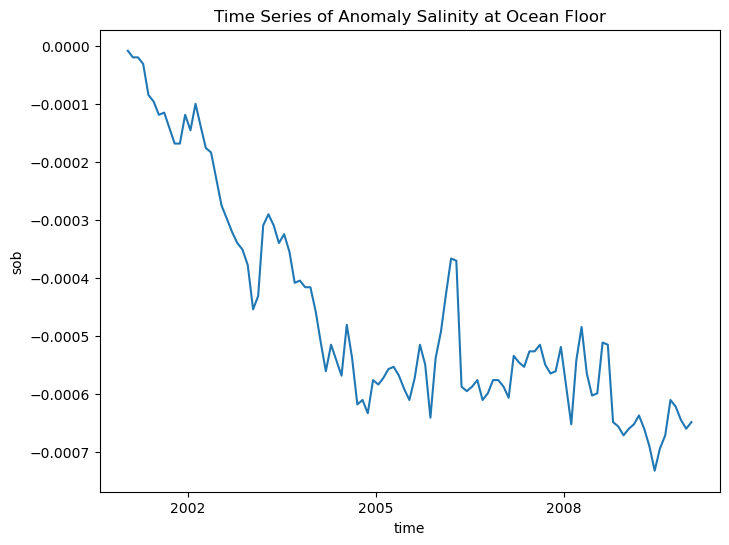

In [32]:
SOanom_bot_time.plot(size=6)
plt.title("Time Series of Anomaly Salinity at Ocean Floor")

In [69]:
SOcont_top_shelf = control_SO.so.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOcont_mid_shelf = control_SO.so.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOcont_bot_shelf = control_SOB.sob.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

SOpert_top_shelf = trial_SO.so.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOpert_mid_shelf = trial_SO.so.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
SOpert_bot_shelf = trial_SOB.sob.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

In [70]:
SOanom_top_shelf = SOpert_top_shelf - SOcont_top_shelf
SOanom_mid_shelf = SOpert_mid_shelf - SOcont_mid_shelf
SOanom_bot_shelf = SOpert_bot_shelf - SOcont_bot_shelf

Text(0.5, 1.0, 'Time Series of Shelf Anomaly Salinity at Ocean Surface')

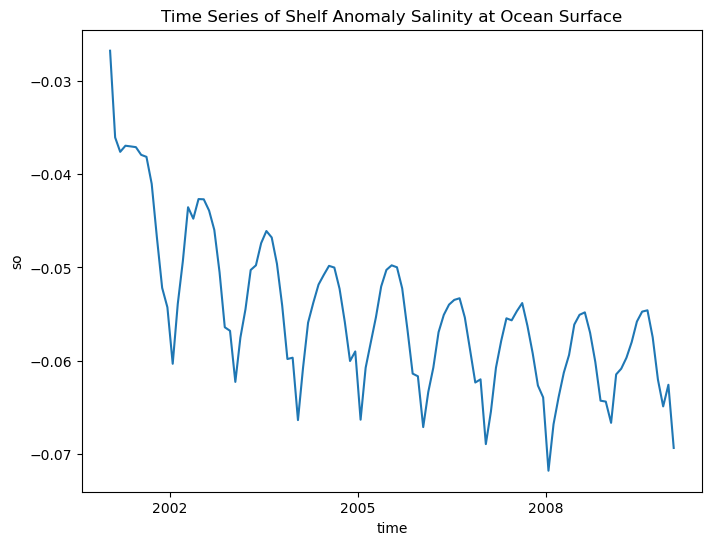

In [72]:
SOanom_top_shelf.plot(size=6)
plt.title("Time Series of Shelf Anomaly Salinity at Ocean Surface")

Text(0.5, 1.0, 'Time Series of Shelf Anomaly Salinity at 500 m Depth')

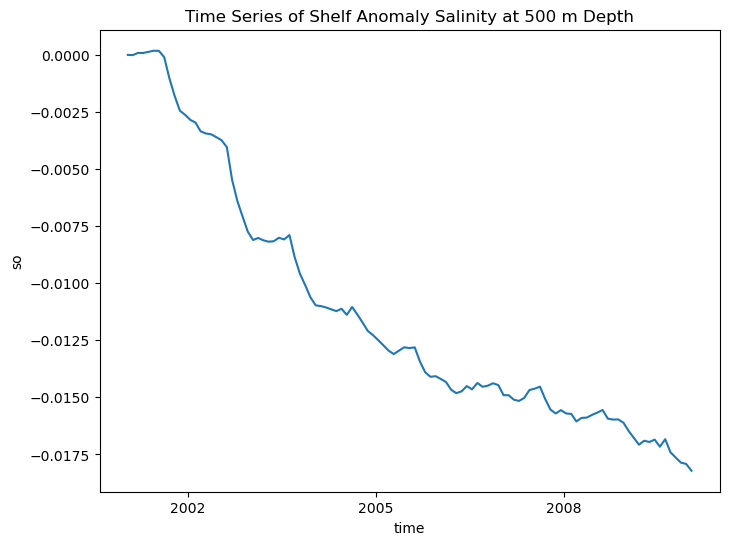

In [73]:
SOanom_mid_shelf.plot(size=6)
plt.title("Time Series of Shelf Anomaly Salinity at 500 m Depth")

Text(0.5, 1.0, 'Time Series of Shelf Anomaly Salinity at Ocean Floor')

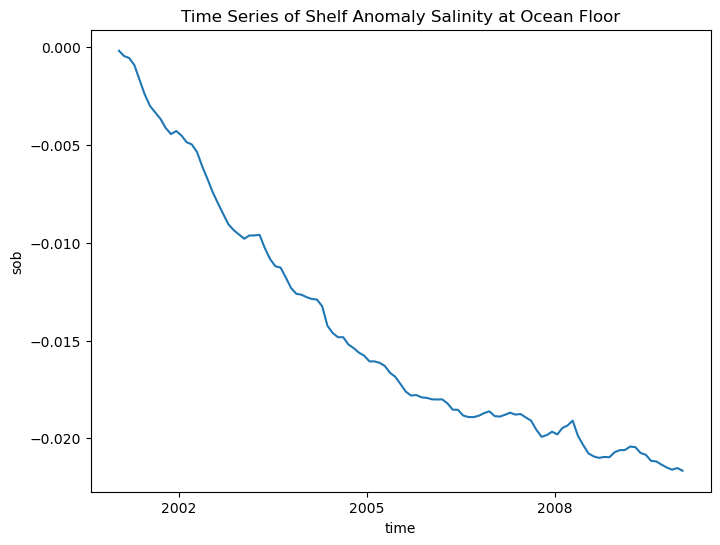

In [74]:
SOanom_bot_shelf.plot(size=6)
plt.title("Time Series of Shelf Anomaly Salinity at Ocean Floor")